In [1363]:
# If ipytest isn't installed in your environment, run:
# %pip install -q ipytest pytest
# %pip install matplotlib

## configuration

In [1364]:
from numpy.f2py.crackfortran import word_pattern

# "Księga [numer księgi]"
CHAPTER_TITLE_REGEX_PL = r'^\s*Księga\s+(\w+|[IVXLCDM\d]+)\s*$'
# allows removing all the intro up to ISBN
UPTO_ISBN_REGEX = r'^.*?ISBN\s+978-83-\d{3}-\d{4}-\d{1,2}\s*'

CONFIG = {
    'top_longest_words_number': 10,
    'top_most_common_words_number': 10,
    # I'm not sure if we want ignored workds in histagram, so I made it configurable
    "include_ignored_words_in_histogram": True,
    'ignored_words': [
        'i', 'a', 'że', 'lub', "w", "się", "z", "na", "nie", "jak", "do", "to", "o", "za",
        "po", "co", "od", "lecz", "bo", "gdy", "ja",
    ],
    'ignored_regexps': [
        UPTO_ISBN_REGEX,
        CHAPTER_TITLE_REGEX_PL
    ],
}

#### Technical functions (file loading, handling errors, generating histogram chart etc)

In [1365]:
def ensure_string(input_text):
    """Raises TypeError if input_text is not a string."""
    if not isinstance(input_text, str):
        raise TypeError(
            f"expected a string, got {type(input_text).__name__}"
        )


def load_text(filename):
    """Loads text from a file."""
    ensure_string(filename)
    if not filename.endswith(".txt"):
        raise ValueError(f"Expected a .txt file, got {filename!r} instead.")
    file = open(filename, "r", encoding="utf-8")
    text = file.read()
    file.close()

    return text

import matplotlib.pyplot as plt
from collections import Counter

def words_length_histogram(words_list):
    word_lengths = [len(s) for s in words_list]

    length_counter = Counter(word_lengths)

    sorted_lengths = sorted(length_counter.keys())
    counts = [length_counter[length] for length in sorted_lengths]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(sorted_lengths, counts, color='skyblue', edgecolor='black')

    ax.set_xlabel('Długość słowa', fontsize=14)
    ax.set_ylabel('Częstotliwość', fontsize=14)
    ax.set_title('Histogram Długości Słów', fontsize=16)

    ax.set_xticks(sorted_lengths)

    for length, count in zip(sorted_lengths, counts):
        ax.text(length, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()



In [1366]:
import re

def tokenize_by_regexp(input_text):
    """Tokenizes text using a regular expression to find word boundaries.
    - Converts text to lowercase.
    - Extracts word-like tokens (letters, numbers, underscores, digits).
    - Raises TypeError for non-string inputs.
    """
    ensure_string(input_text)
    return re.findall(r"\b\w+\b", input_text.lower())


In [1367]:
def words_by_length(words_list, n=None):
    words = sorted(set(words_list), key=len, reverse=True)
    return words if n is None else words[:n]


In [1368]:
def words_by_frequency(words_list, n=None, ignored_words=[]):
    # word_counts = Counter(words_list)

    ignored_set = set(ignored_words)

    filtered_words = [
        word for word in words_list
        if word not in ignored_set
    ]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(n)


In [1369]:
def cleanup_text(text, config=CONFIG):
    """Removes phrases from text by defined regexps."""
    flags = re.IGNORECASE | re.DOTALL | re.MULTILINE
    for regexp in config.get("ignored_regexps", []):
        text = re.sub(regexp, "", text, flags=flags)

    # in the end we do not clear out the ignored words at this level, as we need them for histogram
    if not config.get("include_ignored_words_in_histogram", False):
        for word in config.get("ignored_words", []):
            regex = r'\b' + re.escape(word) + r'\b'
            text = re.sub(regex, '', text, flags=re.IGNORECASE)
    return text

### Pan Tadeusz - Adam Mickiewicz. Najdłuższe i najczęściej występujęce słowa

In [1379]:
def ex01_imp(filename = 'pan-tadeusz.txt'):
    cleaned_text = cleanup_text(load_text(filename))

    all_words = tokenize_by_regexp(cleaned_text)

    print("\nNajdłuższe słowa w Panu Tadeuszu to:\n")
    top_longest_words = words_by_length(all_words, CONFIG['top_longest_words_number'])

    for word in top_longest_words:
        print(f" - {word} długość: {len(word)}")

    print("\nNajczęściej występujące słowa w Panu Tadeuszu to:\n")
    top_most_common_words = words_by_frequency(all_words, CONFIG['top_most_common_words_number'], CONFIG['ignored_words'])

    for word, count in top_most_common_words:
        print(f" - {word}: {count}")
    return all_words

# all_words = ex01_imp('one-more-cup-of-coffee.txt')
all_words = ex01_imp('pan-tadeusz.txt')



Najdłuższe słowa w Panu Tadeuszu to:

 - niebezpieczeństwach długość: 19
 - białopiotrowiczowi długość: 18
 - niebezpieczeństwem długość: 18
 - najprzykładniejszy długość: 18
 - nierozstrzygniony długość: 17
 - białopiotrowiczem długość: 17
 - niebezpieczeństwo długość: 17
 - niebezpieczeństwa długość: 17
 - błogosławieństwo długość: 16
 - dźwięcznostrunne długość: 16

Najczęściej występujące słowa w Panu Tadeuszu to:

 - już: 313
 - tak: 312
 - pan: 181
 - jest: 179
 - ale: 176
 - był: 165
 - nim: 157
 - rzekł: 155
 - go: 153
 - tylko: 149


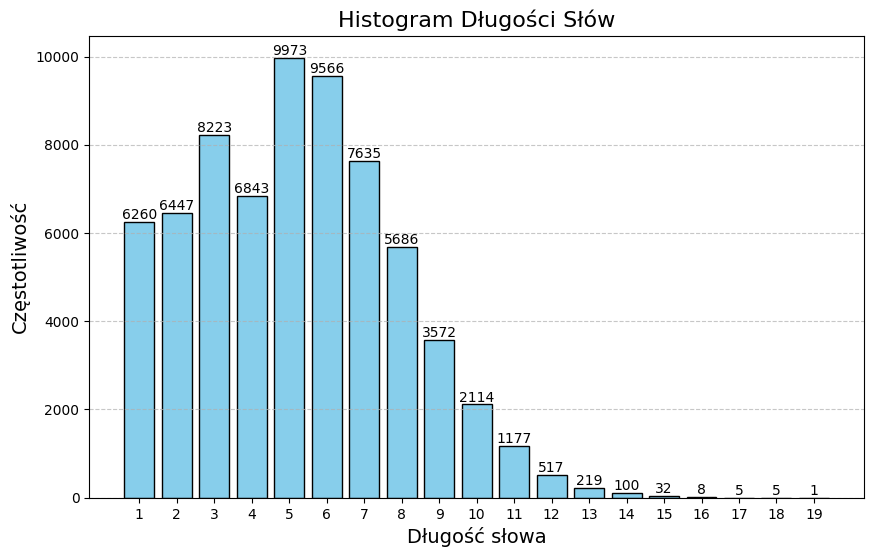

In [1371]:
words_length_histogram(all_words)

### Unit Tests

In [1372]:
import ipytest
import pytest

ipytest.autoconfig()  # integrate pytest with the notebook

test words_by_length

In [1373]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("Ala ma kota", 3, ["kota", "ala", "ma"]),
        ("Ala ma kota", 1, ["kota"]),
        # words should be unique on the list
        ("Ala ma kota, Ala ma Kota", 100, ["kota", "ala", "ma"]),
        ("To be, or not to be, that is the question.", 2, ["question", "that"])
    ],
)
def test_words_by_length(text, n, expected):
    words_list = tokenize_by_regexp(text)
    assert words_by_length(words_list, n) == expected

@pytest.mark.parametrize(
    "text, expected",
    [
        ("Ala ma kota", ["kota", "ala", "ma"]),
        ("To be, or not to be, that is the question.", ['question', 'that', 'not', 'the', 'to', 'be', 'or', 'is'])
    ],
)
def test_words_by_length_without_lenght(text, expected):
    words_list = tokenize_by_regexp(text)
    print(words_by_length(words_list))
    print(" expected:")
    print(expected)
    assert words_by_length(words_list) == expected

test tokenize_by_regexp

In [1374]:
@pytest.mark.parametrize(
    "text, expected",
    [
        ("123 abc", ["123", "abc"]),
        # skipping interpunction
        ("Ala ma kota, kot ma Alę!", ["ala", "ma", "kota", "kot", "ma", "alę"]),
        # other witespace characters
        ("123 abc\n456\tdef", ["123", "abc", "456", "def"]),
        # edge cases
        ("", []),
        ("   \t\n  ", []),
    ],
)
def test_tokenize_by_regexp(text, expected):
    assert tokenize_by_regexp(text) == expected

test most_common_words

In [1375]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("world world world", 1, [('world', 3)]),
        ("world world world", 3, [('world', 3)]),
        ("world \nworld \t world. ", 4, [('world', 3)]),
        ("World WORLD, worLD!", 3, [('world', 3)]),
        ("Hello WORLD! Hello World, Hello Bob", 3, [('hello', 3), ('world', 2), ("bob", 1)]),

        ("", 3, []),
        (" \n\t ", 3, []),
    ]
)
def test_words_by_frequency(text, n, expected):
    words_list = tokenize_by_regexp(text)
    assert words_by_frequency(words_list, n) == expected

In [1376]:
# dla testowego pliku z teksrami piosenek [Chorus] [Verse 1] etc
LYRICS_TAGS_REGEX = r'\[.*?\]'

DEFAULT_CONFIG_EN = {
    'top_longest_words_number': 10,
    'top_most_common_words_number': 10,
    'ignored_words': ['a', 'the', 'do'],
    "include_ignored_words_in_histogram": True,
    'ignored_regexps': [
        LYRICS_TAGS_REGEX
    ]
}

def test_cleanup_text():
    text = load_text('one-more-cup-of-coffee.txt')
    config = DEFAULT_CONFIG_EN
    cleaned_text = cleanup_text(text, config)

    assert "[Chorus]" not in cleaned_text
    assert "[Verse 1]" not in cleaned_text
    assert "[Verse 2]" not in cleaned_text

    # "the" is part of "annother"
    assert "another" in cleaned_text
    # "the" is in ignored words, but we want it
    assert " the " in cleaned_text

    assert "One more cup of coffee for the road" in cleaned_text

In [1377]:
ipytest.run()

..................................                                                           [100%]
34 passed in 0.05s


<ExitCode.OK: 0>